# Метод распространения меток на основе случайных блужданий (RW-LPA)

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Макрушин С.В. "Лекция 5: Случайные блуждания на графах"
* Документация:
    * https://networkx.org/documentation/stable/reference/generated/networkx.linalg.graphmatrix.adjacency_matrix.html
    * https://numpy.org/doc/stable/reference/generated/numpy.linalg.matrix_power.html
    * https://numpy.org/doc/stable/reference/generated/numpy.linalg.inv.html

## Вопросы для совместного обсуждения

1\. Обсудите принцип работы алгоритма RW-LPA, принцип построения блочной матрицы $\mathbf{P}$ и матрицы начального состояния меток $\mathbf{Y_0}$.

$$\mathbf{P} = \begin{pmatrix}
\mathbf{P}_{ll}& \mathbf{P}_{lu}\\
\mathbf{P}_{ul}& \mathbf{P}_{uu}\\
\end{pmatrix} = \begin{pmatrix}
\mathbf{I}& \mathbf{0}\\
\mathbf{P}_{ul}& \mathbf{P}_{uu}\\
\end{pmatrix}$$

$$\mathbf{Y_0} = \begin{pmatrix}
\mathbf{Y_{l}}\\
\mathbf{Y_{u}}\\
\end{pmatrix}= \begin{pmatrix}
\mathbf{Y_{l}}\\
\mathbf{0}\\
\end{pmatrix}$$

In [1]:
import networkx as nx

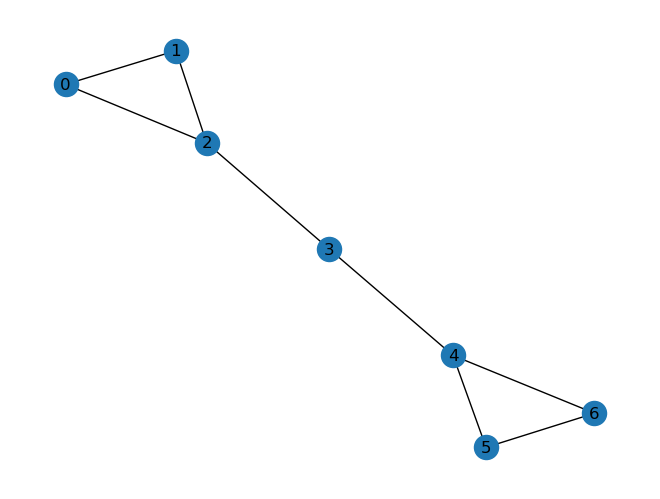

In [2]:
G = nx.barbell_graph(3, 1)
nx.draw(G, with_labels=True)

In [3]:
comm1 = [1]
comm2 = [5]

unlabeled = list(set(G).difference(comm1).difference(comm2))
len(unlabeled)
n_comms = 2

In [4]:
nodes_order = [*comm1, *comm2, *unlabeled]
# nodes_order
A = nx.adjacency_matrix(G, nodelist=nodes_order).toarray()
# модификация матрицы смежности ...
A

array([[0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1],
       [1, 0, 0, 1, 0, 0, 0],
       [1, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 1, 0],
       [0, 1, 0, 0, 1, 0, 1],
       [0, 1, 0, 0, 0, 1, 0]])

In [5]:
import numpy as np

In [6]:
Y0 = np.zeros((len(G), 2))
Y0[0, 0] = 1
Y0[1, 1] = 1
Y0

array([[1., 0.],
       [0., 1.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

## Задачи для самостоятельного решения

In [7]:
import networkx as nx
import random
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

<p class="task" id="1"></p>

1\. Загрузите граф Karate Club. Получите значения атрибута `club`, хранящегося на узлах. Выберите случайным образом 4 узла, относящихся к клубу `Mr. Hi` и 4 узла, относящихся к клубу `Officer`. Получите матрицу смежности, в которой узлы перенумерованы  таким образом, чтобы строки и столбцы с номерами 0, 1, ... 7 принадлежали узлам, которые были выбраны на предыдущем шаге.

- [ ] Проверено на семинаре

In [8]:
random.seed(0)

G = nx.karate_club_graph()
clubs = nx.get_node_attributes(G, 'club')
hi = [n for n, c in clubs.items() if c == 'Mr. Hi']
officer = [n for n, c in clubs.items() if c == 'Officer']
hi, officer

([0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21],
 [9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [9]:
s1 = random.sample(hi, 4)
s2 = random.sample(officer, 4)
s1, s2

([13, 16, 0, 4], [33, 32, 23, 29])

In [10]:
unlabeled = list(set(G).difference(s1).difference(s2))
nodes_order = [*s1, *s2, *unlabeled]
A = nx.adjacency_matrix(G, nodelist=nodes_order).toarray()
A

array([[0, 0, 3, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [3, 0, 0, ..., 0, 0, 2],
       ...,
       [0, 0, 0, ..., 0, 0, 2],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 2, ..., 2, 0, 0]])

<p class="task" id="2"></p>

2\. Получите блочную матрицу $\mathbf{P}$ и матрицу начального состояния меток $\mathbf{Y_0} \in \{0,1\}^{N\times2}$
$$\mathbf{P} = \begin{pmatrix}
\mathbf{P}_{ll}& \mathbf{P}_{lu}\\
\mathbf{P}_{ul}& \mathbf{P}_{uu}\\
\end{pmatrix} = \begin{pmatrix}
\mathbf{I}& \mathbf{0}\\
\mathbf{P}_{ul}& \mathbf{P}_{uu}\\
\end{pmatrix}$$

$$\mathbf{Y_0} = \begin{pmatrix}
\mathbf{Y_{l}}\\
\mathbf{Y_{u}}\\
\end{pmatrix}= \begin{pmatrix}
\mathbf{Y_{l}}\\
\mathbf{0}\\
\end{pmatrix}$$

Выведите на экран след матрицы $\mathbf{P}$. Выведите на экран количество ненулевых элементов матрицы $\mathbf{Y_0}$

- [ ] Проверено на семинаре

In [11]:
D = np.diag(A.sum(axis=1))
P = np.linalg.inv(D) @ A

P_ul = P[(n:=(len(s1)+len(s2))):, :n]
P_uu = P[n:, n:]

P_ul.shape, P_uu.shape

((26, 8), (26, 26))

In [12]:
I = np.eye(n)
O = np.zeros((n, len(G)-n))
P_rw = np.vstack([np.hstack([I, O]), np.hstack([P_ul, P_uu])])

P_rw.shape

(34, 34)

In [13]:
P.trace(), P_rw.trace()

(0.0, 8.0)

In [14]:
Y0 = np.zeros((len(G), 2))
Y0[:len(s1), 0] = 1
Y0[len(s1):n, 1] = 1

Y0

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [15]:
np.count_nonzero(Y0)

8

<p class="task" id="3"></p>

3\. Известно, что для блочной матрицы справедливо:

$$\mathbf{P}^{\infty} =
\begin{pmatrix}
\mathbf{I}& \mathbf{0}\\
(\mathbf{I}-\mathbf{P}_{uu})^{-1}\mathbf{P}_{ul}& \mathbf{0}\\
\end{pmatrix}$$

Получите оценку $\mathbf{P}^{\infty}$ путем возведения матрицы в достаточно большую степень. Свяжите блоки матрицы с отдельными переменными `P_ll`, `P_lu`, `P_ul`, `P_uu` и продемонстрируйте, что каждый блок полученной матрицы удовлетворяет формуле выше при помощи функции `np.allclose`.

- [ ] Проверено на семинаре

In [16]:
P_inf = np.linalg.matrix_power(P_rw, 100)
P_inf

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [8.21199122e-02, 0.00000000e+00, 1.89717180e-01, ...,
        9.25989889e-21, 1.15814008e-20, 2.23795856e-20],
       [8.06397301e-02, 0.00000000e+00, 1.61164732e-01, ...,
        6.31712769e-21, 7.90112341e-21, 1.52667074e-20],
       [1.36051198e-02, 0.00000000e+00, 1.54618762e-01, ...,
        6.39416730e-21, 7.99684674e-21, 1.54546034e-20]])

In [17]:
P_ll_inf = P_inf[:n, :n]
P_lu_inf = P_inf[:n, n:]
P_ul_inf = P_inf[n:, :n]
P_uu_inf = P_inf[n:, n:]

all((np.allclose(P_ll_inf, I), np.allclose(P_lu_inf, 0),
    np.allclose(P_ul_inf, np.linalg.inv(np.eye(P_uu.shape[0]) - P_uu) @ P_ul),
    np.allclose(P_uu_inf, 0)))

True

<p class="task" id="4"></p>

4\. Используя Базовый вариант RW-LPA , расставьте метки для всех узлов. Визуализируйте сеть, показав цветом контура вокруг узла принадлежность узла к одному из сообществ, а цветом цветом заливки узла - сообщество, к которому узел был отнесен алгоритмом.

![](https://i.imgur.com/R4ZbGEV.png)

- [ ] Проверено на семинаре

In [18]:
Y_prev = Y0
Y_next = P_rw @ Y0

while np.linalg.norm(Y_next - Y_prev) > 1e-10:
    Y_prev = Y_next.copy()
    Y_next = P_rw @ Y_prev

pred = np.argmax(Y_next, axis=1)
pred

array([0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [19]:
labels = [0 if clubs[node] == 'Mr. Hi' else 1 for node in nodes_order]
print(classification_report(labels[n:], pred[n:], target_names=['Mr. Hi', 'Officer']))

              precision    recall  f1-score   support

      Mr. Hi       1.00      0.92      0.96        13
     Officer       0.93      1.00      0.96        13

    accuracy                           0.96        26
   macro avg       0.96      0.96      0.96        26
weighted avg       0.96      0.96      0.96        26



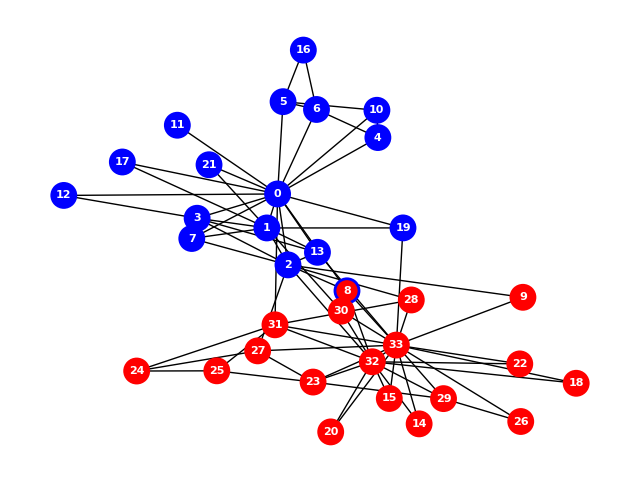

In [20]:
pos = nx.spring_layout(G, seed=0)

plt.figure(figsize=(8, 6))
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_nodes(G, pos, nodelist=nodes_order, linewidths=2,
    node_color=['red' if p else 'blue' for p in pred],
    edgecolors=['red' if l else 'blue' for l in labels])

nx.draw_networkx_labels(G, pos, font_size=8, font_color='white', font_weight='bold')
plt.axis('off')
plt.show()